# Case Study A-Z: A Machine Learning powered Strategy (DNN)

_Disclaimer: <br>
The following illustrative example is for general information and educational purposes only. <br>
It is neither investment advice nor a recommendation to trade, invest or take whatsoever actions.<br>
The below code should only be used in combination with an Oanda/FXCM Practice/Demo Account and NOT with a Live Trading Account._

## Getting and Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("seaborn")
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from datetime import datetime
import pickle
from DNNModel import *
# Preprocessing data
from talib import abstract
import tpqoa
import fxcmpy
from datetime import timedelta
import time

/tmp/ipykernel_64390/979973331.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
2023-05-18 22:44:31.807170: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 22:44:31.880629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 22:44:31.882033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 22:44:33.079586: W tensorflow/compiler/tf2tensorrt/utils/py_utils

## Load data

In [2]:
def get_data():
    data = pd.read_csv("DNN_data.csv", parse_dates = ["time"], index_col = "time")
    return data

raw_data = get_data()

### View data

In [3]:
raw_data 

,EUR_USD
time,
2017-01-02 23:20:00,1.04574
2017-01-02 23:40:00,1.04608
2017-01-03 00:00:00,1.04575
2017-01-03 00:20:00,1.04672
2017-01-03 00:40:00,1.04696
...,...
2019-12-30 23:00:00,1.12012
2019-12-30 23:20:00,1.12030
2019-12-30 23:40:00,1.12018


In [4]:
symbol = raw_data.columns[0]
symbol

'EUR_USD'

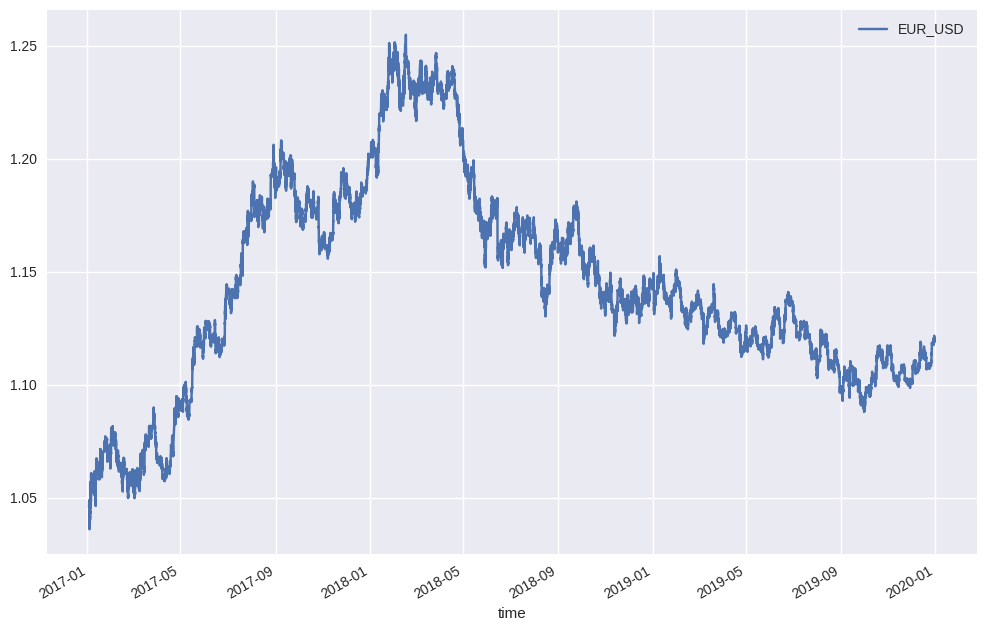

In [5]:
raw_data.plot(figsize = (12, 8))
plt.show()

## Adding Label/Features

In [6]:

def get_features(df, lags = 5, window = 50):
    cols = []
    features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]
    df["returns"] = np.log(df[symbol] / df[symbol].shift())
    
    df["dir"] = np.where(df["returns"] > 0, 1, 0)
    df["sma"] = df[symbol].rolling(window).mean() - df[symbol].rolling(150).mean()
    df["boll"] = (df[symbol] - df[symbol].rolling(window).mean()) / df[symbol].rolling(window).std()
    df["min"] = df[symbol].rolling(window).min() / df[symbol] - 1
    df["max"] = df[symbol].rolling(window).max() / df[symbol] - 1
    df["mom"] = df["returns"].rolling(3).mean()
    df["vol"] = df["returns"].rolling(window).std()
    
    for f in features:
        for lag in range(1, lags + 1):
            col = "{}_lag_{}".format(f, lag)
            df[col] = df[f].shift(lag)
            cols.append(col)
            
    df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
    cols.append('Ask_Dir')

    df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
    cols.append('SMA')
    df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
    cols.append('SMA_Dir')

    df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
    cols.append('RSI')
    df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
    cols.append('RSI_Dir')

    df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    cols.append('fastk')
    cols.append('fastd')
    df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
    cols.append('fastk_Dir')
    df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
    cols.append('fastd_Dir')             
                
    df.dropna(inplace = True)
    
    return df, cols 

In [7]:
data, columns = get_features(df=raw_data)

In [8]:
print(columns)
data

['dir_lag_1', 'dir_lag_2', 'dir_lag_3', 'dir_lag_4', 'dir_lag_5', 'sma_lag_1', 'sma_lag_2', 'sma_lag_3', 'sma_lag_4', 'sma_lag_5', 'boll_lag_1', 'boll_lag_2', 'boll_lag_3', 'boll_lag_4', 'boll_lag_5', 'min_lag_1', 'min_lag_2', 'min_lag_3', 'min_lag_4', 'min_lag_5', 'max_lag_1', 'max_lag_2', 'max_lag_3', 'max_lag_4', 'max_lag_5', 'mom_lag_1', 'mom_lag_2', 'mom_lag_3', 'mom_lag_4', 'mom_lag_5', 'vol_lag_1', 'vol_lag_2', 'vol_lag_3', 'vol_lag_4', 'vol_lag_5', 'Ask_Dir', 'SMA', 'SMA_Dir', 'RSI', 'RSI_Dir', 'fastk', 'fastd', 'fastk_Dir', 'fastd_Dir']


,EUR_USD,returns,dir,sma,boll,min,max,mom,vol,dir_lag_1,...,vol_lag_5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,,,,,,,,,,
2017-01-05 02:40:00,1.05124,-0.00101,0,0.00339,1.32277,-0.00809,0.00268,-0.00004,0.00086,1.00000,...,0.00080,1,0.00020,1,45.79101,1,32.77533,52.85494,1,1
2017-01-05 03:00:00,1.05150,0.00025,1,0.00351,1.35516,-0.00833,0.00243,-0.00015,0.00086,0.00000,...,0.00084,1,0.00022,1,50.47578,1,85.03783,59.12614,1,1
2017-01-05 03:20:00,1.05230,0.00076,1,0.00365,1.55709,-0.00908,0.00167,-0.00000,0.00086,1.00000,...,0.00085,0,0.00028,1,52.31412,0,100.00000,72.60439,0,1
2017-01-05 03:40:00,1.05192,-0.00036,0,0.00380,1.37543,-0.00873,0.00203,0.00022,0.00086,1.00000,...,0.00085,1,0.00029,0,48.06058,1,35.27942,73.43908,1,0
2017-01-05 04:00:00,1.05204,0.00011,1,0.00392,1.35764,-0.00884,0.00192,0.00017,0.00085,0.00000,...,0.00085,0,0.00019,0,49.94179,0,63.71572,66.33171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:00:00,1.12012,0.00008,1,0.00316,0.11606,-0.00136,0.00145,0.00006,0.00041,0.00000,...,0.00040,1,-0.00001,1,50.90174,1,53.44446,51.14815,1,0
2019-12-30 23:20:00,1.12030,0.00016,1,0.00312,0.33557,-0.00152,0.00129,-0.00003,0.00040,1.00000,...,0.00040,0,-0.00001,1,51.68920,0,63.82901,39.09116,0,1
2019-12-30 23:40:00,1.12018,-0.00011,0,0.00306,0.15542,-0.00141,0.00139,0.00004,0.00039,1.00000,...,0.00040,1,0.00001,0,48.84045,1,26.72987,48.00111,1,1


## Splitting into Train and Test Set

In [9]:
split = int(len(data)*0.66)
split

36716

In [10]:
train = data.iloc[:split].copy()
train

,EUR_USD,returns,dir,sma,boll,min,max,mom,vol,dir_lag_1,...,vol_lag_5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,,,,,,,,,,
2017-01-05 02:40:00,1.05124,-0.00101,0,0.00339,1.32277,-0.00809,0.00268,-0.00004,0.00086,1.00000,...,0.00080,1,0.00020,1,45.79101,1,32.77533,52.85494,1,1
2017-01-05 03:00:00,1.05150,0.00025,1,0.00351,1.35516,-0.00833,0.00243,-0.00015,0.00086,0.00000,...,0.00084,1,0.00022,1,50.47578,1,85.03783,59.12614,1,1
2017-01-05 03:20:00,1.05230,0.00076,1,0.00365,1.55709,-0.00908,0.00167,-0.00000,0.00086,1.00000,...,0.00085,0,0.00028,1,52.31412,0,100.00000,72.60439,0,1
2017-01-05 03:40:00,1.05192,-0.00036,0,0.00380,1.37543,-0.00873,0.00203,0.00022,0.00086,1.00000,...,0.00085,1,0.00029,0,48.06058,1,35.27942,73.43908,1,0
2017-01-05 04:00:00,1.05204,0.00011,1,0.00392,1.35764,-0.00884,0.00192,0.00017,0.00085,0.00000,...,0.00085,0,0.00019,0,49.94179,0,63.71572,66.33171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-23 23:40:00,1.13718,0.00006,1,-0.00202,-0.94581,-0.00113,0.00890,0.00020,0.00078,1.00000,...,0.00078,0,-0.00000,1,50.67051,0,74.59340,62.50327,0,0
2018-12-24 00:00:00,1.13724,0.00005,1,-0.00219,-0.89554,-0.00119,0.00885,0.00011,0.00078,1.00000,...,0.00078,1,0.00002,1,50.60928,1,0.00000,42.81816,1,1
2018-12-24 00:20:00,1.13755,0.00027,1,-0.00237,-0.77108,-0.00146,0.00857,0.00013,0.00077,1.00000,...,0.00078,0,0.00012,1,52.18414,0,94.71730,56.43690,0,0


In [11]:
test = data.iloc[split:].copy()
test

,EUR_USD,returns,dir,sma,boll,min,max,mom,vol,dir_lag_1,...,vol_lag_5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,,,,,,,,,,
2018-12-24 01:20:00,1.13780,-0.00004,0,-0.00290,-0.61860,-0.00168,0.00582,0.00007,0.00076,1.00000,...,0.00078,0,0.00013,0,49.53093,0,0.00000,17.87936,0,0
2018-12-24 01:40:00,1.13770,-0.00009,0,-0.00303,-0.62974,-0.00159,0.00466,0.00000,0.00073,0.00000,...,0.00078,1,0.00012,0,49.02814,1,0.00000,9.69133,1,1
2018-12-24 02:00:00,1.13806,0.00032,1,-0.00313,-0.45011,-0.00191,0.00418,0.00006,0.00072,0.00000,...,0.00077,0,0.00006,1,53.01649,0,100.00000,33.33333,0,0
2018-12-24 02:20:00,1.13791,-0.00013,0,-0.00322,-0.48362,-0.00178,0.00431,0.00003,0.00072,1.00000,...,0.00077,1,0.00012,1,48.43314,1,0.00000,33.33333,1,1
2018-12-24 02:40:00,1.13865,0.00065,1,-0.00331,-0.12870,-0.00242,0.00340,0.00028,0.00072,0.00000,...,0.00077,0,0.00016,0,55.71894,0,100.00000,66.66667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:00:00,1.12012,0.00008,1,0.00316,0.11606,-0.00136,0.00145,0.00006,0.00041,0.00000,...,0.00040,1,-0.00001,1,50.90174,1,53.44446,51.14815,1,0
2019-12-30 23:20:00,1.12030,0.00016,1,0.00312,0.33557,-0.00152,0.00129,-0.00003,0.00040,1.00000,...,0.00040,0,-0.00001,1,51.68920,0,63.82901,39.09116,0,1
2019-12-30 23:40:00,1.12018,-0.00011,0,0.00306,0.15542,-0.00141,0.00139,0.00004,0.00039,1.00000,...,0.00040,1,0.00001,0,48.84045,1,26.72987,48.00111,1,1


## Feature Scaling (Standardization)

In [12]:
train[columns]

,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,...,vol_lag_5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,,,,,,,,,,
2017-01-05 02:40:00,1.00000,1.00000,0.00000,0.00000,1.00000,0.00327,0.00314,0.00302,0.00290,0.00275,...,0.00080,1,0.00020,1,45.79101,1,32.77533,52.85494,1,1
2017-01-05 03:00:00,0.00000,1.00000,1.00000,0.00000,0.00000,0.00339,0.00327,0.00314,0.00302,0.00290,...,0.00084,1,0.00022,1,50.47578,1,85.03783,59.12614,1,1
2017-01-05 03:20:00,1.00000,0.00000,1.00000,1.00000,0.00000,0.00351,0.00339,0.00327,0.00314,0.00302,...,0.00085,0,0.00028,1,52.31412,0,100.00000,72.60439,0,1
2017-01-05 03:40:00,1.00000,1.00000,0.00000,1.00000,1.00000,0.00365,0.00351,0.00339,0.00327,0.00314,...,0.00085,1,0.00029,0,48.06058,1,35.27942,73.43908,1,0
2017-01-05 04:00:00,0.00000,1.00000,1.00000,0.00000,1.00000,0.00380,0.00365,0.00351,0.00339,0.00327,...,0.00085,0,0.00019,0,49.94179,0,63.71572,66.33171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-23 23:40:00,1.00000,1.00000,1.00000,0.00000,1.00000,-0.00186,-0.00170,-0.00153,-0.00138,-0.00122,...,0.00078,0,-0.00000,1,50.67051,0,74.59340,62.50327,0,0
2018-12-24 00:00:00,1.00000,1.00000,1.00000,1.00000,0.00000,-0.00202,-0.00186,-0.00170,-0.00153,-0.00138,...,0.00078,1,0.00002,1,50.60928,1,0.00000,42.81816,1,1
2018-12-24 00:20:00,1.00000,1.00000,1.00000,1.00000,1.00000,-0.00219,-0.00202,-0.00186,-0.00170,-0.00153,...,0.00078,0,0.00012,1,52.18414,0,94.71730,56.43690,0,0


In [13]:
# train set parameters (mu, std) for standardization
mu, std = train.mean(), train.std() 

In [14]:
std

EUR_USD       0.05121
returns       0.00054
dir           0.49996
sma           0.00287
boll          1.44147
min           0.00237
max           0.00225
mom           0.00031
vol           0.00018
dir_lag_1     0.49996
dir_lag_2     0.49996
dir_lag_3     0.49996
dir_lag_4     0.49996
dir_lag_5     0.49996
sma_lag_1     0.00287
sma_lag_2     0.00287
sma_lag_3     0.00287
sma_lag_4     0.00287
sma_lag_5     0.00287
boll_lag_1    1.44150
boll_lag_2    1.44152
boll_lag_3    1.44154
boll_lag_4    1.44157
boll_lag_5    1.44163
min_lag_1     0.00237
min_lag_2     0.00237
min_lag_3     0.00237
min_lag_4     0.00237
min_lag_5     0.00237
max_lag_1     0.00225
max_lag_2     0.00225
max_lag_3     0.00225
max_lag_4     0.00225
max_lag_5     0.00225
mom_lag_1     0.00031
mom_lag_2     0.00031
mom_lag_3     0.00031
mom_lag_4     0.00031
mom_lag_5     0.00031
vol_lag_1     0.00018
vol_lag_2     0.00018
vol_lag_3     0.00018
vol_lag_4     0.00018
vol_lag_5     0.00018
Ask_Dir       0.49997
SMA       

In [15]:
train_s = (train - mu) / std 

In [16]:
train_s

,EUR_USD,returns,dir,sma,boll,min,max,mom,vol,dir_lag_1,...,vol_lag_5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,,,,,,,,,,
2017-01-05 02:40:00,-2.04937,-1.86478,-0.98635,1.13118,0.90750,-2.34316,0.12084,-0.15119,1.95530,1.01381,...,1.63281,1.01259,1.29798,1.00304,-1.04468,1.01254,-0.44849,0.14198,1.07250,1.05280
2017-01-05 03:00:00,-2.04429,0.45268,1.01381,1.17515,0.92997,-2.44672,0.01062,-0.48070,1.94553,-0.98635,...,1.84657,1.01259,1.42796,1.00304,0.11961,1.01254,0.92598,0.43627,1.07250,1.05280
2017-01-05 03:20:00,-2.02867,1.40031,1.01381,1.22385,1.07006,-2.76504,-0.32820,-0.00694,1.96957,1.01381,...,1.88609,-0.98754,1.84894,1.00304,0.57649,-0.98759,1.31947,1.06878,-0.93238,1.05280
2017-01-05 03:40:00,-2.03609,-0.67081,-0.98635,1.27513,0.94404,-2.61390,-0.16733,0.69350,1.96584,1.01381,...,1.87732,1.01259,1.90176,-0.99694,-0.48063,1.01254,-0.38263,1.10796,1.07250,-0.94982
2017-01-05 04:00:00,-2.03375,0.20669,1.01381,1.31799,0.93169,-2.66164,-0.21814,0.54919,1.90611,-0.98635,...,1.87806,-0.98754,1.20844,-0.99694,-0.01310,-0.98759,0.36522,0.77442,-0.93238,-0.94982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-23 23:40:00,-0.37115,0.10973,1.01381,-0.75175,-0.66629,0.59187,2.88473,0.63144,1.49751,1.01381,...,1.47850,-0.98754,-0.04290,1.00304,0.16801,-0.98759,0.65130,0.59476,-0.93238,-0.94982
2018-12-24 00:00:00,-0.36998,0.09349,1.01381,-0.81123,-0.63141,0.56962,2.86106,0.35506,1.48584,1.01381,...,1.51162,1.01259,0.13017,1.00304,0.15279,1.01254,-1.31046,-0.32903,1.07250,1.05280
2018-12-24 00:20:00,-0.36393,0.49931,1.01381,-0.87442,-0.54507,0.45469,2.73883,0.41211,1.45186,1.01381,...,1.51646,-0.98754,0.76502,1.00304,0.54418,-0.98759,1.18054,0.31007,-0.93238,-0.94982


In [17]:
train_s.describe()

,EUR_USD,returns,dir,sma,boll,min,max,mom,vol,dir_lag_1,...,vol_lag_5,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
count,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,...,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000,36716.00000
mean,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,...,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-2.14427,-15.49849,-0.98635,-4.52905,-4.35636,-7.23579,-1.07180,-11.84536,-2.02052,-0.98635,...,-2.02040,-0.98754,-8.64890,-0.99694,-7.96458,-0.98759,-1.31046,-2.33841,-0.93238,-0.94982
25%,-0.50472,-0.45358,-0.98635,-0.67758,-0.73979,-0.48565,-0.75323,-0.46080,-0.67030,-0.98635,...,-0.67030,-0.98754,-0.49296,-0.99694,-0.55965,-0.98759,-1.04545,-0.72232,-0.93238,-0.94982
50%,0.16948,-0.00393,-0.98635,-0.02444,0.01612,0.28270,-0.27229,-0.00694,-0.18088,-0.98635,...,-0.18091,-0.98754,0.00013,-0.99694,-0.00430,-0.98759,-0.00715,0.00173,-0.93238,-0.94982
75%,0.58278,0.45663,1.01381,0.65822,0.74353,0.74441,0.50010,0.45772,0.43962,1.01381,...,0.43953,1.01259,0.48930,1.00304,0.55945,1.01254,1.04643,0.72414,1.07250,1.05280
max,1.92844,28.48640,1.01381,3.40071,4.37520,1.07084,9.18993,18.74853,10.35454,1.01381,...,10.35365,1.01259,10.05550,1.00304,8.71986,1.01254,1.31947,2.35441,1.07250,1.05280


## Creating and Fitting the DNN Model

In [18]:
# fitting a DNN model with 3 Hidden Layers (50 nodes each) and dropout regularization

set_seeds(100)
model = create_model(hl = 3, hu = 50, dropout = True, input_dim = len(columns))
model.fit(x = train_s[columns], y = train["dir"], epochs = 50, verbose = False,
          validation_split = 0.2, shuffle = False, class_weight = cw(train))

In [19]:
model.evaluate(train_s[columns], train["dir"]) # evaluate the fit on the train set

1148/1148 [==============================] - 2s 2ms/step - loss: 0.0439 - accuracy: 0.9814


[0.04388856515288353, 0.9813705086708069]

In [20]:
pred = model.predict(train_s[columns]) # prediction (probabilities)
pred

1148/1148 [==============================] - 2s 2ms/step


array([[1.4303775e-12],
       [9.9939132e-01],
       [1.0000000e+00],
       ...,
       [9.9999976e-01],
       [9.9864638e-01],
       [9.9947381e-01]], dtype=float32)

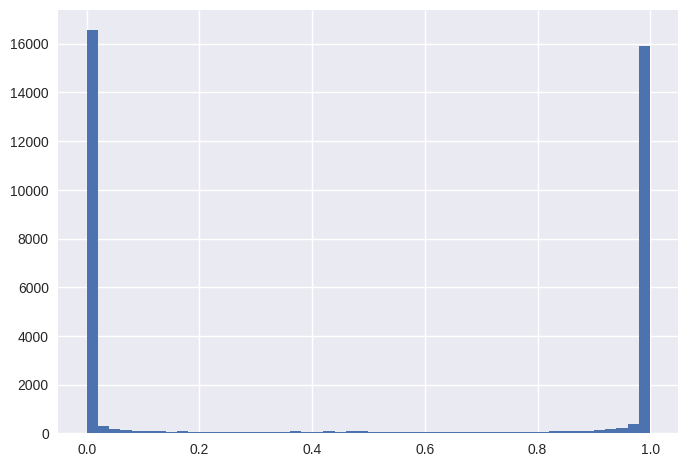

In [21]:
plt.hist(pred, bins = 50)
plt.show()

## Out-Sample Prediction and Forward Testing

In [22]:
# standardization of test set features (with train set parameters!!!)
test_s = (test - mu) / std 

In [23]:
model.evaluate(test_s[columns], test["dir"])

592/592 [==============================] - 1s 2ms/step - loss: 0.0528 - accuracy: 0.9778


[0.05275460332632065, 0.9778482913970947]

In [24]:
pred = model.predict(test_s[columns])
pred

592/592 [==============================] - 1s 2ms/step


array([[3.0756589e-02],
       [2.6522728e-04],
       [1.0000000e+00],
       ...,
       [3.6706131e-06],
       [1.2713791e-03],
       [9.9999702e-01]], dtype=float32)

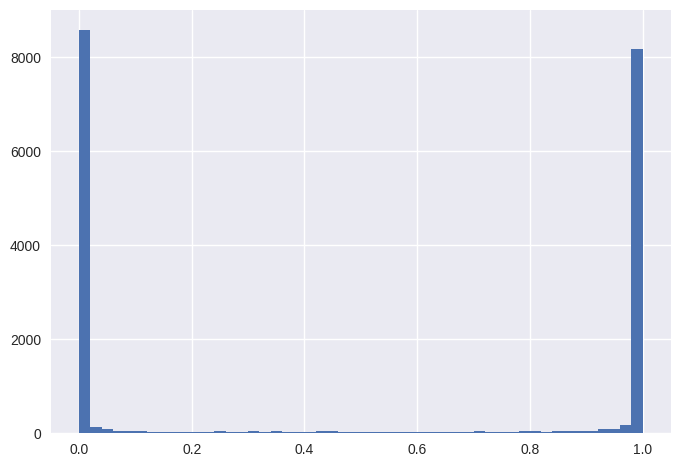

In [25]:
plt.hist(pred, bins = 50);

In [26]:
test["proba"] = model.predict(test_s[columns])

592/592 [==============================] - 1s 2ms/step


In [27]:
test["position"] = np.where(test.proba < 0.47, -1, np.nan) # 1. short where proba < 0.47

In [28]:
test["position"] = np.where(test.proba > 0.53, 1, test.position) # 2. long where proba > 0.53

In [29]:
test.index = test.index.tz_localize("UTC")
test["NYTime"] = test.index.tz_convert("America/New_York")
test["hour"] = test.NYTime.dt.hour

In [30]:
test["position"] = np.where(~test.hour.between(2, 12), 0, test.position) # 3. neutral in non-busy hours

In [31]:
test["position"] = test.position.ffill().fillna(0) # 4. in all other cases: hold position

In [32]:
test.position.value_counts(dropna = False)

0.00000     10237
-1.00000     4412
1.00000      4266
Name: position, dtype: int64

In [33]:
test["strategy"] = test["position"] * test["returns"]

In [34]:
test["creturns"] = test["returns"].cumsum().apply(np.exp)
test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)

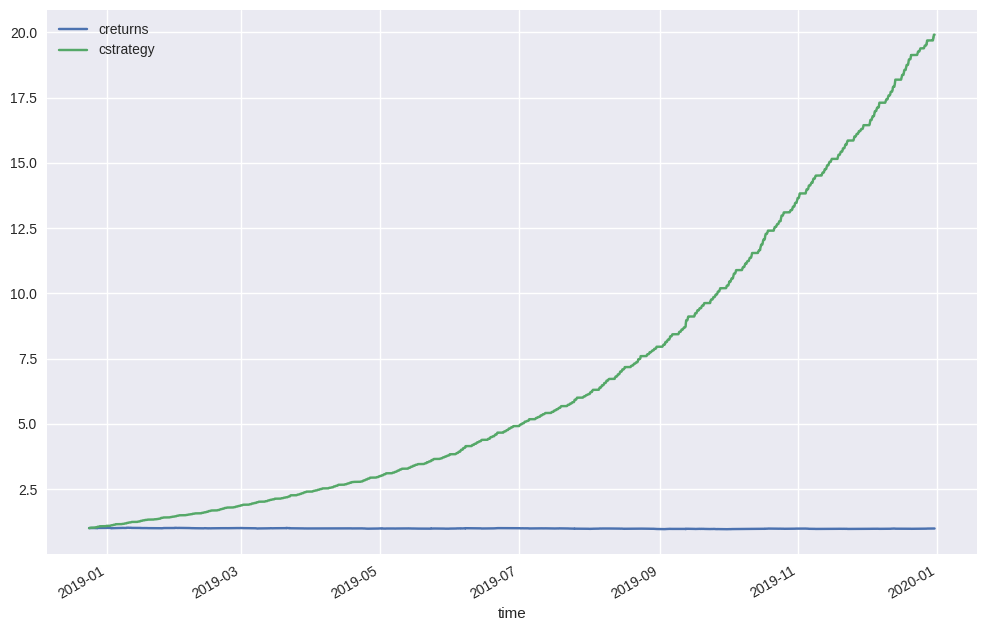

In [35]:
test[["creturns", "cstrategy"]].plot(figsize = (12, 8))
plt.show()

In [36]:
ptc = 0.000059

In [37]:
test["trades"] = test.position.diff().abs()

In [38]:
test.trades.value_counts()

0.00000    14066
2.00000     4322
1.00000      526
Name: trades, dtype: int64

In [39]:
test["strategy_net"] = test.strategy - test.trades * ptc

In [40]:
test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)

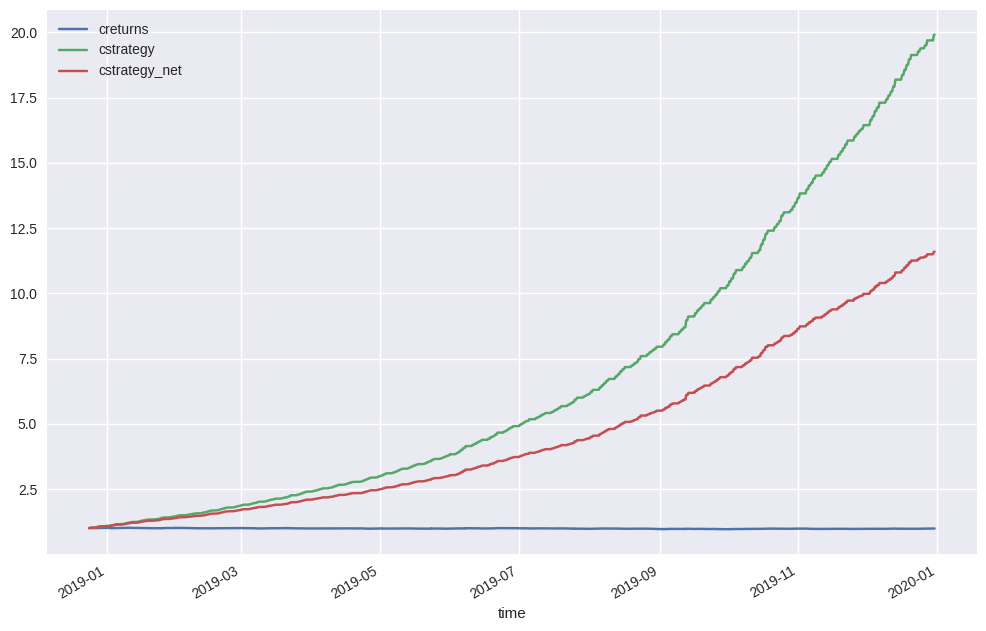

In [41]:
test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
plt.show()

# Test loop - Delete

In [42]:
test.columns

Index(['EUR_USD', 'returns', 'dir', 'sma', 'boll', 'min', 'max', 'mom', 'vol',
       'dir_lag_1', 'dir_lag_2', 'dir_lag_3', 'dir_lag_4', 'dir_lag_5',
       'sma_lag_1', 'sma_lag_2', 'sma_lag_3', 'sma_lag_4', 'sma_lag_5',
       'boll_lag_1', 'boll_lag_2', 'boll_lag_3', 'boll_lag_4', 'boll_lag_5',
       'min_lag_1', 'min_lag_2', 'min_lag_3', 'min_lag_4', 'min_lag_5',
       'max_lag_1', 'max_lag_2', 'max_lag_3', 'max_lag_4', 'max_lag_5',
       'mom_lag_1', 'mom_lag_2', 'mom_lag_3', 'mom_lag_4', 'mom_lag_5',
       'vol_lag_1', 'vol_lag_2', 'vol_lag_3', 'vol_lag_4', 'vol_lag_5',
       'Ask_Dir', 'SMA', 'SMA_Dir', 'RSI', 'RSI_Dir', 'fastk', 'fastd',
       'fastk_Dir', 'fastd_Dir', 'proba', 'position', 'NYTime', 'hour',
       'strategy', 'creturns', 'cstrategy', 'trades', 'strategy_net',
       'cstrategy_net'],
      dtype='object')

## Downlatest data to build new model

In [43]:

latest_data = yf.Ticker('EURUSD=X').history(period='1mo', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                   interval='5m', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                   actions=False)

In [44]:
latest_data.resample('20min').fillna(method=None)

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-04-18 21:40:00+01:00,NaN,NaN,NaN,NaN,NaN
2023-04-18 22:00:00+01:00,1.09745,1.09782,1.09745,1.09757,0.00000
2023-04-18 22:20:00+01:00,1.09769,1.09769,1.09733,1.09733,0.00000
2023-04-18 22:40:00+01:00,1.09733,1.09745,1.09709,1.09721,0.00000
2023-04-18 23:00:00+01:00,1.09769,1.09806,1.09769,1.09769,0.00000
...,...,...,...,...,...
2023-05-18 20:20:00+01:00,1.07701,1.07712,1.07701,1.07701,0.00000
2023-05-18 20:40:00+01:00,1.07759,1.07770,1.07759,1.07770,0.00000
2023-05-18 21:00:00+01:00,1.07770,1.07770,1.07759,1.07759,0.00000


<Axes: xlabel='Datetime'>

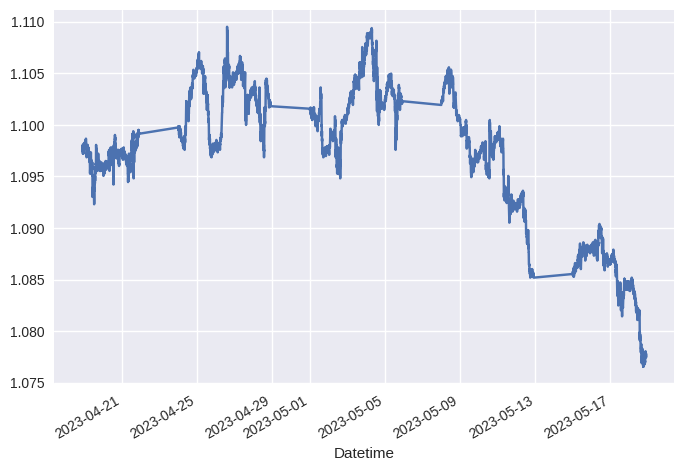

In [45]:
latest_data["Close"].plot()

## Saving Model and Parameters

In [46]:
model.save("DNN_model")

2023-05-18 22:47:16.662971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2023-05-18 22:47:16.684108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2023-05-18 22:47:16.704837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2023-05-18 22:47:16

INFO:tensorflow:Assets written to: DNN_model/assets


In [47]:
params = {"mu":mu, "std":std}

In [48]:
params

{'mu': EUR_USD       1.15619
 returns       0.00000
 dir           0.49314
 sma           0.00014
 boll          0.01463
 min          -0.00254
 max           0.00241
 mom           0.00000
 vol           0.00051
 dir_lag_1     0.49314
 dir_lag_2     0.49314
 dir_lag_3     0.49311
 dir_lag_4     0.49308
 dir_lag_5     0.49308
 sma_lag_1     0.00014
 sma_lag_2     0.00014
 sma_lag_3     0.00014
 sma_lag_4     0.00014
 sma_lag_5     0.00014
 boll_lag_1    0.01469
 boll_lag_2    0.01476
 boll_lag_3    0.01482
 boll_lag_4    0.01490
 boll_lag_5    0.01500
 min_lag_1    -0.00254
 min_lag_2    -0.00254
 min_lag_3    -0.00254
 min_lag_4    -0.00254
 min_lag_5    -0.00254
 max_lag_1     0.00241
 max_lag_2     0.00241
 max_lag_3     0.00241
 max_lag_4     0.00241
 max_lag_5     0.00241
 mom_lag_1     0.00000
 mom_lag_2     0.00000
 mom_lag_3     0.00000
 mom_lag_4     0.00000
 mom_lag_5     0.00000
 vol_lag_1     0.00051
 vol_lag_2     0.00051
 vol_lag_3     0.00051
 vol_lag_4     0.00051
 vol_

In [49]:
pickle.dump(params, open("params.pkl", "wb"))

## Implementation

__Loading Model and Parameters__

In [50]:
# Loading the model
import keras
model = keras.models.load_model("DNN_model")

In [51]:
model

In [52]:
# Loading mu and std
import pickle
params = pickle.load(open("params.pkl", "rb"))
mu = params["mu"]
std = params["std"]

__[FXCM] Implementation__

In [53]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

#api.get_open_positions()

In [54]:
api.close()

In [55]:
col = ["tradeId", "amountK", "currency", "grossPL", "isBuy"]

In [56]:
class DNNTrader():
    def __init__(self, instrument, bar_length, window, lags):
        self.instrument = instrument
        self.bar_length = pd.to_timedelta(bar_length) 
        self.tick_data = None
        self.raw_data = None
        self.data = None 
        self.ticks = 0
        
        #*****************add strategy-specific attributes here******************
        self.window = window
        self.lags = lags
        #************************************************************************       
    
    def get_most_recent(self, period = "m1", number = 10000):
        while True:  
            time.sleep(5)
            df = api.get_candles(self.instrument, number = number, period = period, columns = ["bidclose", "askclose"])
            df[self.instrument] = (df.bidclose + df.askclose) / 2
            df = df[self.instrument].to_frame()
            df = df.resample(self.bar_length, label = "right").last().dropna().iloc[:-1]
            self.raw_data = df.copy()
            self.last_bar = self.raw_data.index[-1]
            if pd.to_datetime(datetime.utcnow()) - self.last_bar < self.bar_length:
                self.start_time = pd.to_datetime(datetime.utcnow()) # NEW -> Start Time of Trading Session
                break
    
    
    def get_features(self, df, lags = 5, window = 50):
        cols = []
        features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]
        df["returns"] = np.log(df[symbol] / df[symbol].shift())
        
        df["dir"] = np.where(df["returns"] > 0, 1, 0)
        df["sma"] = df[symbol].rolling(window).mean() - df[symbol].rolling(150).mean()
        df["boll"] = (df[symbol] - df[symbol].rolling(window).mean()) / df[symbol].rolling(window).std()
        df["min"] = df[symbol].rolling(window).min() / df[symbol] - 1
        df["max"] = df[symbol].rolling(window).max() / df[symbol] - 1
        df["mom"] = df["returns"].rolling(3).mean()
        df["vol"] = df["returns"].rolling(window).std()
        
        for f in features:
            for lag in range(1, lags + 1):
                col = "{}_lag_{}".format(f, lag)
                df[col] = df[f].shift(lag)
                cols.append(col)
                
        df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
        cols.append('Ask_Dir')

        df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
        cols.append('SMA')
        df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
        cols.append('SMA_Dir')

        df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
        cols.append('RSI')
        df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
        cols.append('RSI_Dir')

        df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        cols.append('fastk')
        cols.append('fastd')
        df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
        cols.append('fastk_Dir')
        df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
        cols.append('fastd_Dir')             
                    
        df.dropna(inplace = True)
        df = df[cols]
        
        return df, cols 
    
    
    def get_tick_data(self, data, dataframe):
        
        self.ticks += 1
        print(self.ticks, end = " ", flush = True)
        
        recent_tick = pd.to_datetime(data["Updated"], unit = "ms")
        
        if recent_tick - self.last_bar > self.bar_length:
            self.tick_data = dataframe.loc[self.last_bar:, ["Bid", "Ask"]]
            self.tick_data[self.instrument] = (self.tick_data.Ask + self.tick_data.Bid)/2
            self.tick_data = self.tick_data[self.instrument].to_frame()
            self.resample_and_join()
            self.define_strategy() 
            self.execute_trades()
            
    def resample_and_join(self):
        self.raw_data = self.raw_data.append(self.tick_data.resample(self.bar_length, 
                                                             label="right").last().ffill().iloc[:-1])
        self.last_bar = self.raw_data.index[-1]  
        
    def define_strategy(self): # "strategy-specific"
        df, columns = self.get_features(df = self.raw_data.copy())
        #******************** define your strategy here ************************
        print(columns)
        
    def execute_trades(self):
        print(datetime.now())

In [63]:
class DNNTrader():
    
    def __init__(self, instrument, bar_length, window, lags, model, mu, std, units):
        self.instrument = instrument
        self.bar_length = pd.to_timedelta(bar_length) 
        self.tick_data = None
        self.raw_data = None
        self.data = None 
        self.ticks = 0
        self.last_bar = None  
        self.units = units
        self.position = 0
        
        #*****************add strategy-specific attributes here******************
        self.window = window
        self.lags = lags
        self.model = model
        self.mu = mu
        self.std = std
        #************************************************************************        
    
    def get_most_recent(self, period = "m1", number = 10000):
        while True:  
            time.sleep(5)
            df = api.get_candles(self.instrument, number = number, period = period, columns = ["bidclose", "askclose"])
            df[self.instrument] = (df.bidclose + df.askclose) / 2
            df = df[self.instrument].to_frame()
            df = df.resample(self.bar_length, label = "right").last().dropna().iloc[:-1]
            self.raw_data = df.copy()
            self.last_bar = self.raw_data.index[-1]
            if pd.to_datetime(datetime.utcnow()) - self.last_bar < self.bar_length:
                self.start_time = pd.to_datetime(datetime.utcnow()) # NEW -> Start Time of Trading Session
                break
    
    def get_tick_data(self, data, dataframe):
        
        self.ticks += 1
        print(self.ticks, end = " ", flush = True)
        
        recent_tick = pd.to_datetime(data["Updated"], unit = "ms")
        
        if recent_tick - self.last_bar > self.bar_length:
            self.tick_data = dataframe.loc[self.last_bar:, ["Bid", "Ask"]]
            self.tick_data[self.instrument] = (self.tick_data.Ask + self.tick_data.Bid)/2
            self.tick_data = self.tick_data[self.instrument].to_frame()
            self.resample_and_join()
            self.define_strategy() 
            self.execute_trades()
            
    def resample_and_join(self):
        self.raw_data = self.raw_data.append(self.tick_data.resample(self.bar_length, 
                                                             label="right").last().ffill().iloc[:-1])
        self.last_bar = self.raw_data.index[-1]  
        
    def define_strategy(self): # "strategy-specific"
        df = self.raw_data.copy()
        
        #******************** define your strategy here ************************
        df = df.append(self.tick_data.iloc[-1]) # append latest tick (== open price of current bar)
        df["returns"] = np.log(df[self.instrument] / df[self.instrument].shift())
        df["dir"] = np.where(df["returns"] > 0, 1, 0)
        df["sma"] = df[self.instrument].rolling(self.window).mean() - df[self.instrument].rolling(150).mean()
        df["boll"] = (df[self.instrument] - df[self.instrument].rolling(self.window).mean()) / df[self.instrument].rolling(self.window).std()
        df["min"] = df[self.instrument].rolling(self.window).min() / df[self.instrument] - 1
        df["max"] = df[self.instrument].rolling(self.window).max() / df[self.instrument] - 1
        df["mom"] = df["returns"].rolling(3).mean()
        df["vol"] = df["returns"].rolling(self.window).std()
        df.dropna(inplace = True)
        
        # create lags
        self.cols = []
        features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

        for f in features:
            for lag in range(1, self.lags + 1):
                col = "{}_lag_{}".format(f, lag)
                df[col] = df[f].shift(lag)
                self.cols.append(col)
        df.dropna(inplace = True)
        
        # standardization
        df_s = (df - self.mu) / self.std
        # predict
        df["proba"] = self.model.predict(df_s[self.cols])
        
        #determine positions
        df = df.loc[self.start_time:].copy() # starting with first live_stream bar (removing historical bars)
        df["position"] = np.where(df.proba < 0.47, -1, np.nan)
        df["position"] = np.where(df.proba > 0.53, 1, df.position)
        df["position"] = df.position.ffill().fillna(0) # start with neutral position if no strong signal
        #***********************************************************************
        
        self.data = df.copy()
    
    def execute_trades(self):
        if self.data["position"].iloc[-1] == 1:
            if self.position == 0:
                order = api.create_market_buy_order(self.instrument, self.units)
                self.report_trade(order, "GOING LONG")  
            elif self.position == -1:
                order = api.create_market_buy_order(self.instrument, self.units * 2)
                self.report_trade(order, "GOING LONG")  
            self.position = 1
        elif self.data["position"].iloc[-1] == -1: 
            if self.position == 0:
                order = api.create_market_sell_order(self.instrument, self.units)
                self.report_trade(order, "GOING SHORT")  
            elif self.position == 1:
                order = api.create_market_sell_order(self.instrument, self.units * 2)
                self.report_trade(order, "GOING SHORT")  
            self.position = -1
        elif self.data["position"].iloc[-1] == 0: 
            if self.position == -1:
                order = api.create_market_buy_order(self.instrument, self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            elif self.position == 1:
                order = api.create_market_sell_order(self.instrument, self.units)
                self.report_trade(order, "GOING NEUTRAL")  
            self.position = 0

    def report_trade(self, order, going):
        time = order.get_time()
        units = api.get_open_positions().amountK.iloc[-1]
        price = api.get_open_positions().open.iloc[-1]
        unreal_pl = api.get_open_positions().grossPL.sum()
        print("\n" + 100* "-")
        print("{} | {}".format(time, going))
        print("{} | units = {} | price = {} | Unreal. P&L = {}".format(time, units, price, unreal_pl))
        print(100 * "-" + "\n")

In [64]:
trader = DNNTrader("EUR/USD", bar_length = "20min", 
                   window = 50, lags = 5, model = model, mu = mu, std = std, units = 100)

In [65]:
trader.get_most_recent()
api.subscribe_market_data(trader.instrument, (trader.get_tick_data, ))

ValueError: Instrument must be one of ().